In [2]:
import sys
sys.path.insert(1, '../')

from pckgs.import_pckg import *
from pckgs.units import *
# importing FIRAS data
from FIRAS import *

# importing generic constants and functions
from const_func_general import *
# importing distortion specific constants and functions
from cons_func_distortion import *


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from pckgs.plot_params import params
import matplotlib
matplotlib.rcParams.update(params)
#plt.rcParams['font.family'] = 'DeJavu Serif'
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
# importing data for plotting
# COBE-FIRAS, McDermott et al (1911.05086)
McDermott_20_FIRAS_2Dary = np.transpose( np.array( pd.read_csv('../data/McDermott_20_FIRAS.csv') ) )

# COBE-FIRAS from Caputo et al  (2002.05165): Homogeneous and Inhomogeneous
Caputo_20_FIRAS_2Dary   = np.transpose( np.array( pd.read_csv('../data/Caputo_20_FIRAS.csv') ) )

Caputo_20_FIRAS_ho_2Dary   = np.transpose( np.array( pd.read_csv('../data/Caputo_20_FIRAS_ho.csv') ) )
Caputo_20_FIRAS_inho_2Dary = np.transpose( np.array( pd.read_csv('../data/Caputo_20_FIRAS_inho.csv') ) )

# PIXIE Projection from Caputo et al (2002.05165): inhomogeneous
Caputo_20_PIXIE_inho_2Dary = np.transpose( np.array( pd.read_csv('../data/Caputo_20_PIXIE_inho.csv') ) )  #Caputo et al from 2002.05165

# COBE-FIRAS from Mirizzi et al (0901.0014)
Mirizzi_09_FIRAS_2Dary = np.transpose( np.array( pd.read_csv('../data/Mirizzi_09_FIRAS.csv') ) ) 

Caputo_20_PIXIE_inho_ = np.array( pd.read_csv('../data/Caputo_20_PIXIE_inho.csv') ) 


# Importing other experiments

# Cavendish
Cavendish_2Dary = np.transpose( np.array( pd.read_csv('../data/Cavendish.csv') ) )

# CROWS
CROWS_ = np.array( pd.read_csv('../data/CROWS_.csv') ) 

# Dark SRF (2301.11512 Romanenko et al)
DarkSRF_ = np.array( pd.read_csv('../data/DarkSRF.csv') ) 


# Dark SRF Pathfinder Projection (2203.12714 Snowmass)
DarkSRF23_Pathfinder_Proj_ = np.array( pd.read_csv('../data/DarkSRF23_Pathfinder_Proj_.csv') ) 

# Solar Luminosity (2304.12907 Li&Xu)
SolarLuminosity_ = np.array( pd.read_csv('../data/SolarLuminosity_.csv') ) 

# Xenon Solar (2112.12116 XENON1T Solar DP)
XenonSolar_ = np.array( pd.read_csv('../data/XenonSolar_.csv') ) 

# Jupyter (2312.06746 Yan&Li&Fan)
Jupiter_2Dary = np.transpose( np.array( pd.read_csv('../data/Jupiter.csv') ) )

# Earth (Phys.Rev.Lett. 73 (1994) 514-517)
Earth_2Dary   = np.transpose( np.array( pd.read_csv('../data/Earth.csv') ) )

In [4]:
# Importing probability


file_name = "../data/Probability.npz"
if file_name is not None:
    file = np.load(file_name)
# x:   1D array
x_1Dary_P_import = file['x_P_scan_ary']

# -------------------------------------------------------
# mAp: 1D array
mAp_1Dary_P_import = file['mAp_P_scan_ary']

# -------------------------------------------------------
# P/eps^2: 2D array
P_over_eps2_2Dary_import = file['P_over_eps2_scan_2Dary']


zres_2Dary_import=file['zres_scan_2Dary']


# Interpolation: Log10(P/eps^2), Log10(z_res)
# Input: Log10(mAp), x

Reg_trans= 10**(-100)

log10P_over_eps2_interp = interp2d( np.log10(mAp_1Dary_P_import), x_1Dary_P_import, np.log10(P_over_eps2_2Dary_import + Reg_trans) )
log10zres_interp        = interp2d( np.log10(mAp_1Dary_P_import), x_1Dary_P_import, np.log10(zres_2Dary_import + Reg_trans)  )

# P/eps^2 from 2D interpolation
# Input: Log10(mAp), x
def P_over_eps2_interp(mAp, x):
    
    P_over_eps2_interp = 10**log10P_over_eps2_interp( np.log10(mAp), x )
    
    return P_over_eps2_interp

# zres from 2D interpolation
# Input: Log10(mAp), x
# Note! Here, 'zres_interp' only picks the minimal zres when there is multi solution
def zres_interp(mAp,x):
    
    zres_interp = 10**log10zres_interp( np.log10(mAp), x )
    
    return zres_interp



In [5]:
# Delta_I/eps^2 for RAD universe (Approx)
# x :      1D array N_x
# xp:      1D array N_xp  (integration variable)
# output:  1D array N_x

# ----------------------------------------------------------------------
# M-Term Only
# ----------------------------------------------------------------------
def DeltaI_over_eps2_mu_M_int(x, x_prime_int, m_Aprime, T0, units = 'eV_per_cmSq'):

    # Here I choose x_prime = 0
    z_res = zres_interp(m_Aprime, 0)[0]
    
    # (M-Term Green's Func)
    # Input x is array:
    # 2D array: N_x * N_xp  
    greens_mu_ary = greens_mu_M(x, x_prime_int, z_res, T0, units=units)
    
    # P(A->Ap)/eps^2
    # 1D array: N_xp
    P_over_eps2_ary  = np.transpose(P_over_eps2_interp(m_Aprime, x_prime_int))[0]

    # Delta_I(A->Ap)
    # int over xp
    # 1D array: N_x
    DeltaI_AToAp_over_eps2 = (-1)/(2*zeta(3)) * np.trapz(greens_mu_ary *  x_prime_int**2/(np.exp(x_prime_int)-1) * P_over_eps2_ary, x_prime_int)
    
    return DeltaI_AToAp_over_eps2



# Delta_I/eps^2
# x :      1D array N_x
# xp:      1D array N_xp  (integration variable)
# output:  1D array N_x

# DeltaI/eps^2: Y-part
def DeltaI_over_eps2_Y_int(x, x_prime_int, m_Aprime, T0, units = 'eV_per_cmSq'):
    
    # Here I choose x_prime = 0
    z_res = zres_interp(m_Aprime, 0)[0]
    
    # Green's Func at y-era: Y-part
    # 2D array: N_x * N_xp
    greens_Y_ary = greens_Y(x, x_prime_int, z_res, T0, units=units)
    
    # P(A->Ap)/eps^2
    # 1D array: N_xp
    P_over_eps2_ary = np.transpose( P_over_eps2_interp(m_Aprime, x_prime_int) )[0]
    
    # Delta_I(A->Ap)
    # int over xp
    # 1D array: N_x
    DeltaI_over_eps2_Y = (-1)/(2*zeta(3)) * np.trapz(greens_Y_ary *  x_prime_int**2/(np.exp(x_prime_int)-1) * P_over_eps2_ary, x_prime_int)
    
    return DeltaI_over_eps2_Y



# Delta_I/eps^2: Doppler-part
def DeltaI_over_eps2_Doppler_int(x, x_prime_int, m_Aprime, T0, units = 'eV_per_cmSq'):
    
    # Here I choose x_prime = 0
    z_res = zres_interp(m_Aprime, 0)[0]
    
    # Green's Func at y-era: Y-part
    # 2D array: N_x * N_xp
    greens_Doppler_ary = greens_Doppler(x, x_prime_int, z_res, T0, units=units)
    
    
    # P(A->Ap)/eps^2
    # 1D array: N_xp
    P_over_eps2_ary = np.transpose( P_over_eps2_interp(m_Aprime, x_prime_int) )[0]
    
    # Delta_I(A->Ap)
    # int over xp
    # 1D array: N_x
    DeltaI_over_eps2_Doppler = (-1)/(2*zeta(3)) * np.trapz(greens_Doppler_ary *  x_prime_int**2/(np.exp(x_prime_int)-1) * P_over_eps2_ary, x_prime_int)
    
    return DeltaI_over_eps2_Doppler



# Delta_I/eps^2: Doppler-part (small y_gamma limit)
def DeltaI_over_eps2_Doppler_delta(x, m_Aprime, T0, units = 'eV_per_cmSq'):
    
    if   units == 'eV_per_cmSq': # units:    eV * cm^-2 * sr^-1
        prefac = 1
    elif units == 'SI':          # SI units: kg * s^-2 * sr^-1
        prefac = eV_to_J * (1/cm_to_m)**2
    elif units == 'MJy':         # units:    MJy * sr^-1
        prefac = eV_to_J * (1/cm_to_m)**2 * 1e26 / 1e6
    
    # Here I choose x_prime = 0
    z_res = zres_interp(m_Aprime, 0)[0]
    
    # P(A->Ap)/eps^2
    # 1D array: N_x
    # Analytically, we integrate out delta(x_prime -x)
    P_over_eps2_num = np.transpose(P_over_eps2_interp(m_Aprime, x))[0]
    
    # photon energy density
    rho_gamma = (np.pi**2/15) * T0**4  # in eV^4
    
    # tau_ff
    # 1D array N_xp
    # Note: Here, x_prime = x, because of delta(x_prime-x)
    tau = tau_ff(x, z_res)
    
    # Delta_I(A->Ap): small y_gamma limit
    # int over xp
    # 1D array: N_x
    # unit: eV^3
    DeltaI_over_eps2_Doppler_eV3 = - alpha_rho/(2*zeta(3)) * rho_gamma/(4*np.pi) * (2*np.pi/T0) * np.exp(-tau) * x**3/(np.exp(x)-1) * P_over_eps2_num
    
    DeltaI_over_eps2_Doppler = prefac * DeltaI_over_eps2_Doppler_eV3 * (1/cmInv_to_eV)**2
    
    return DeltaI_over_eps2_Doppler



# Delta_I/eps^2: Doppler-part
# When y_gamma<=10^-3, switch approximate Doppler term with delta function
def DeltaI_over_eps2_Doppler_switch(x, x_prime_int, m_Aprime, T0, units = 'eV_per_cmSq'):
    
    # Here I choose x_prime = 0
    z_res = zres_interp(m_Aprime, 0)[0]
    
    # Compton y-parameter (photon)
    y = y_gamma(z_res)
    
    # Determine whether do delta-func approximation
    Approx_Det = (y <= 10**(-3))
    
    # If y<<1   (Approx_Det = True ), we use delta func approx for Doppler,
    # Otherwise (Approx_Det = False), we do numerical integral for Doppler
    DeltaI_over_eps2_Doppler  = np.where(Approx_Det
                          ,DeltaI_over_eps2_Doppler_delta(x,m_Aprime,T0,units=units)
                          ,DeltaI_over_eps2_Doppler_int(x,x_prime_int,m_Aprime,T0,units=units))
    
    return DeltaI_over_eps2_Doppler
    

# DeltaI/eps^2 (Total)
# Full Integration
def DeltaI_over_eps2_y_int(x, x_prime_int, m_Aprime, T0, units = 'eV_per_cmSq'):
    
    # Delta_I(A->Ap)
    # int over xp
    # 1D array: N_x
    DeltaI_over_eps2_y_int = DeltaI_over_eps2_Y_int(x,x_prime_int,m_Aprime,T0,units=units) + DeltaI_over_eps2_Doppler_int(x,x_prime_int,m_Aprime,T0,units=units)
    
    return DeltaI_over_eps2_y_int


# Delta_I/eps^2 (Total): 
# Y-contribution(int) + Doppler-contribution(switch)
def DeltaI_over_eps2_y_switch(x, x_prime_int, m_Aprime, T0, units = 'eV_per_cmSq'):
    
    DeltaI_over_eps2  = DeltaI_over_eps2_Y_int(x,x_prime_int,m_Aprime,T0,units=units) + DeltaI_over_eps2_Doppler_switch(x,x_prime_int,m_Aprime,T0,units=units)

    return DeltaI_over_eps2



# Default values used from 1304.6120v2, z_trans=5.8 * 10**4, Power_trans   = 1.88  

def Ttrans_mu(z, z_trans = 5.8 * 10**4, Power_trans = 1.88):
    
        
    
    Ttrans_mu = 1 - np.exp( -((1+z)/(1+z_trans))**Power_trans )
    
    return Ttrans_mu


# Default values used from 1304.6120v2, z_trans=6e4, Power_trans   = 2.58

def Ttrans_y(z, z_trans = 6e4, Power_trans = 2.58):
    
    Ttrans_y = 1/( 1 + ((1+z)/z_trans)**Power_trans )
    
    return Ttrans_y



def DeltaI_over_eps2_muy_trans(x, x_prime_int, m_Aprime, T0, units = 'eV_per_cmSq'):
    
    # Here I choose x_prime = 0
    z_res = zres_interp(m_Aprime, 0)[0]
    
    # Check whether in the pure-mu region
    mu_era_Check = (z_res > z_trans_2)

    
    DeltaI_over_eps2_muy_trans =  np.where(mu_era_Check,
                                        DeltaI_over_eps2_mu_M_int(x, x_prime_int, m_Aprime, T0, units = units),
                                        ( Ttrans_mu(z_res) * DeltaI_over_eps2_mu_M_int(x, x_prime_int, m_Aprime, T0, units = units) 
                                        + (1-Ttrans_mu(z_res)) * DeltaI_over_eps2_y_switch(x, x_prime_int, m_Aprime, T0, units = units) ) 
                                              )

    return DeltaI_over_eps2_muy_trans






# This is used in chi^2 analysis
def I0_dist_muy_trans(x, x_prime_int, m_Aprime, eps, T0, units = 'eV_per_cmSq'):
    
    # CMB intensity after distortion
    # 1D array: N_x
    I0_dist_y = I0(x, T0, units=units) + eps**2 * DeltaI_over_eps2_muy_trans(x, x_prime_int, m_Aprime, T0, units = units)
    
    return I0_dist_y



# in this function you can pass which type of distortion to be used
#if nothing is passed mu_y_trans distortion with greens functions will be used

def I0_dist( x_ary, x_prime_int, m_Aprime, eps, T0_vary, units = 'MJy', dist_type='greens' ):
    
    # this is distortion with greens functions
    if dist_type=='greens':
            I0_dist_type=I0_dist_muy_trans( x_ary, x_prime_int, m_Aprime, eps, T0_vary, units = 'MJy')    # in MJy/sr
    # this is free streaming distortion
    if dist_type=='freestreaming':
            I0_dist_type=I0( x_ary, T0_vary, units='MJy' ) * ( 1 - eps**2 * np.transpose( P_over_eps2_interp( m_Aprime, x_ary ) )[0] )    # in MJy/sr

    return I0_dist_type


def chi_sq( x_prime_int, m_Aprime, eps, T0_vary, dist_type='greens'):
    
    # [[[Data]]]
    nu_ary = FIRAS_nu_ary  # in cm^-1
    
    # [[[Data]]]
    x_data_ary  = 2 * np.pi * nu_ary * cmInv_to_eV/TCMB_0
    
    x_ary  = 2 * np.pi * nu_ary * cmInv_to_eV/T0_vary
    
    # [[[Data]]]
    # I0 from FIRAS measurement
    I0_data_ary = I0( x_data_ary, TCMB_0, units='MJy' )    # in MJy/sr
    
    # [[[Data]]]
    # Residual of FIRAS
    res_data_ary   = FIRAS_res_ary * 10**(-3)         # in MJy/sr
    
    # [[[Data]]]
    # Uncertainty of FIRAS
    sigma_data_ary = FIRAS_sigma_ary * 10**(-3)       # in MJy/sr
    
    # I0 after distortion
    I0_dist_ary = I0_dist( x_ary, x_prime_int, m_Aprime, eps, T0_vary, 'MJy', dist_type)

    # Difference between data and theory
    diff_I0_ary = I0_data_ary + res_data_ary - I0_dist_ary
    
    # chi^2
    # Here 10^6 change kJy/sr in Cov to MJy/sr
    chi_sq = np.linalg.multi_dot([diff_I0_ary, Cov_Inv, diff_I0_ary]) * 10**6
    
    return chi_sq


# ----------------------------------------------------------------------
# chi^2 with T0 minimization
# ----------------------------------------------------------------------
def chi_sq_minT0( x_prime_int, m_Aprime, eps, dist_type='greens'):
    
    def chi_sq_T0vary(T0_vary):
        
        return chi_sq( x_prime_int, m_Aprime, eps, T0_vary, dist_type )
    
    # full outout of chi^2 minimization over T0
    

    chi_sq_minT0_full_output   = optimize.fmin(chi_sq_T0vary, np.array([TCMB_0]), full_output=True, disp=False)

    
    T0_min_K     = chi_sq_minT0_full_output[0]/K
    
    chi_sq_minT0 = chi_sq_minT0_full_output[1]
    

    return chi_sq_minT0

def chi_sq_minT0_mineps( x_prime_int, m_Aprime, dist_type='greens'):
    
    def chi_sq_minT0_log10epsvary( log10eps ):
        
        return chi_sq_minT0( x_prime_int, m_Aprime, 10**log10eps, dist_type )

    chi_sq_minT0_minlog10eps_full_output =  optimize.fmin(chi_sq_minT0_log10epsvary, np.array([-10]), full_output=True, disp=False)
   
    
    eps_min = 10**chi_sq_minT0_minlog10eps_full_output[0]
    
    chi_sq_minT0_mineps = chi_sq_minT0_minlog10eps_full_output[1]
    
    return chi_sq_minT0_mineps



In [10]:
# free streming calculation
mAp_scan_min = 10**(-16) # in eV
mAp_scan_max = 10**(-3)  # in eV

eps_scan_min = 10**(-8)
eps_scan_max = 1
x_prime_int_test = np.logspace(-3,5,200)

Nscan_mAp = 350
Nscan_eps = 520

m_Ap_ary = np.logspace( np.log10(mAp_scan_min), np.log10(mAp_scan_max), Nscan_mAp )
eps_ary = np.logspace( np.log10(eps_scan_min), np.log10(eps_scan_max), Nscan_eps )


# 2D array: N_eps * N_mAp
TS_2Dary   = np.zeros((len(eps_ary),len(m_Ap_ary)))


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# TS only with diagonal terms
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# TS_ij: (eps_i, mAp_j)
# j: The number of column
for j in tqdm_notebook(range(0, len(m_Ap_ary))):
   
    
    
    m_Ap_j   =  m_Ap_ary[j]
    
    chi_sq_minT0_mineps_value = chi_sq_minT0_mineps( x_prime_int_test, m_Ap_j, 'freestreaming')

    
    
    # i: The number of row
    for i in range(0, len(eps_ary)):
        

        eps_i   =  eps_ary[i]

        TS = chi_sq_minT0( x_prime_int_test, m_Ap_j, eps_i,'freestreaming' ) - chi_sq_minT0_mineps_value
        
        TS_2Dary[i][j] = TS
        



In [11]:

# Exporting Probability and mAp and x_p values
np.savez("../data/freestreaming_FIRAS.npz",
         m_Ap_ary=m_Ap_ary,
         eps_ary=eps_ary,
         TS_2Dary=TS_2Dary
         )


In [12]:
#importing files
file_name = "../data/freestreaming_FIRAS.npz"
#file_name = "../data/transFIRAS_5p8e4_1p88.npz"
if file_name is not None:
    file = np.load(file_name)
# mAp:   1D array
mAp_1Dary_import_freestreaming= file['m_Ap_ary']
# -------------------------------------------------------
# eps: 1D array
eps_1Dary_import_freestreaming = file['eps_ary']

# -------------------------------------------------------
# TS: 2D array
TS_2Dary_import_freestreaming = file['TS_2Dary']



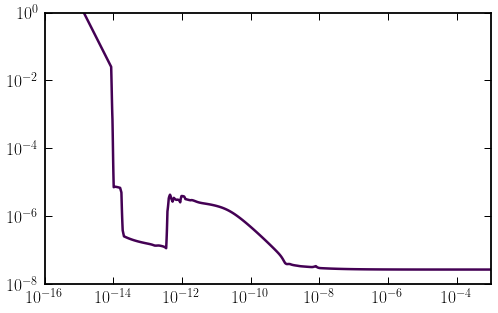

In [13]:

# Delta 95%CL, From PDG Statistics
TS_choose = 2.71

TS_Reg= 0.001

import matplotlib.cm as cm

X_plt, Y_plt     = np.meshgrid( m_Ap_ary, eps_ary )
Z_plt_M          = np.log10( TS_2Dary+TS_Reg )

plt.figure(figsize=(8,5))


plt.xscale('log')
plt.yscale('log')

CS_M  = plt.contour(X_plt, Y_plt, Z_plt_M,  levels = [ np.log10(TS_choose) ])


freestreaming_trans  = np.transpose(CS_M.collections[0].get_paths()[0].vertices )

# Create a sample dataframe
df_freestreaming_trans = pd.DataFrame(freestreaming_trans)

# Save the dataframe to a CSV file
df_freestreaming_trans.to_csv('../data/freestreaming_FIRAS.csv', index=False)



In [14]:
# importing the freestreaming baund
freestreaming_FIRAS =  np.array( pd.read_csv('../data/freestreaming_FIRAS.csv') ) 


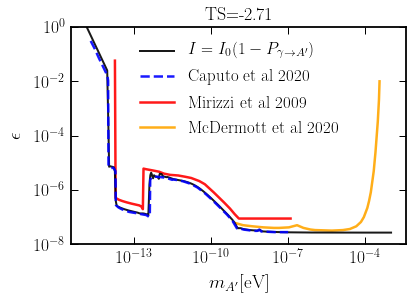

In [15]:


plt.xscale('log')
plt.yscale('log')
plt.plot( freestreaming_FIRAS[0]         , freestreaming_FIRAS[1], label = r'$I=I_0 (1-P_{\gamma \rightarrow A^\prime})$', color='black',linewidth=2.0, zorder=5)
plt.plot( Caputo_20_FIRAS_2Dary[0]   , Caputo_20_FIRAS_2Dary[1], label = r'Caputo et al 2020', color = 'blue',linestyle = 'dashed', zorder=10)
plt.plot( Mirizzi_09_FIRAS_2Dary[0] , Mirizzi_09_FIRAS_2Dary[1], label = r'Mirizzi et al 2009', color = 'red')
plt.plot( McDermott_20_FIRAS_2Dary[0]     , McDermott_20_FIRAS_2Dary[1], label = r'McDermott et al 2020', color = 'orange')


plt.title(r'TS=-2.71')

plt.ylim(1e-8, 1)

plt.xlabel(r'$m_{A^\prime}$[eV]')
plt.ylabel(r'$\epsilon$')

plt.legend()
# plt.show()

plt.savefig('../plots/FIRAS_Bound_freestreaming.pdf', dpi=350)

### Scan $m_{A'}-\epsilon$ Plane


In [23]:
# x_prime_int_test = np.logspace(-4,2,1000)
# x_prime_int_test = np.logspace(-1,2,1000)
x_prime_int_test = np.logspace(-3,5,200)

m_Ap_min = 10**(-10) # in eV
m_Ap_max = 10**(-3)  # in eV
eps_min  = 10**(-8)
eps_max  = 10**2
N_m_Ap   = 50
N_eps    = 50


m_Ap_ary_greens = np.logspace( np.log10(m_Ap_min), np.log10(m_Ap_max), N_m_Ap )
eps_ary_greens  = np.logspace( np.log10(eps_min) , np.log10(eps_max) , N_eps  )


# 2D array: N_eps * N_mAp
TS_2Dary_greens = np.zeros((len(eps_ary_greens),len(m_Ap_ary_greens)))

In [24]:



# TS_ij: (eps_i, mAp_j)
# j: The number of column
for j in tqdm_notebook(range(0, len(m_Ap_ary_greens))):
   
    
    
    m_Ap_j   =  m_Ap_ary_greens[j]
    
    chi_sq_minT0_mineps_value = chi_sq_minT0_mineps( x_prime_int_test, m_Ap_j )
    
    
    # i: The number of row
    for i in range(0, len(eps_ary_greens)):
        
        # print('This is ', i, 'th eps')

        eps_i   =  eps_ary_greens[i]
        
        TS = chi_sq_minT0( x_prime_int_test, m_Ap_j, eps_i ) - chi_sq_minT0_mineps_value
        
        TS_2Dary_greens[i][j] = TS
        



KeyboardInterrupt: 

In [ ]:

# # Exporting Probability and mAp and x_p values
# np.savez("../data/Greens_trans_5p8e4_1p88.npz",
#          m_Ap_ary=m_Ap_ary_greens,
#          eps_ary=eps_ary_greens,
#          TS_2Dary=TS_2Dary_greens
#          )


In [ ]:
# #importing files
# file_name = "../data/Greens_trans_5p8e4_1p88.npz"
# #file_name = "../data/transFIRAS_5p8e4_1p88.npz"
# if file_name is not None:
#     file = np.load(file_name)
# # mAp:   1D array
# m_Ap_ary_greens= file['m_Ap_ary']
# # -------------------------------------------------------
# # eps: 1D array
# eps_ary_greens = file['eps_ary']

# # -------------------------------------------------------
# # TS: 2D array
# TS_2Dary_greens = file['TS_2Dary']



In [ ]:

# Delta 95%CL, From PDG Statistics
TS_choose = 2.71
TS_Reg = 0.001
import matplotlib.cm as cm

X_plt, Y_plt     = np.meshgrid( m_Ap_ary_greens, eps_ary_greens )
Z_plt_M          = np.log10( TS_2Dary_greens +TS_Reg )

plt.figure(figsize=(8,5))


plt.xscale('log')
plt.yscale('log')

CS_M  = plt.contour(X_plt, Y_plt, Z_plt_M,  levels = [ np.log10(TS_choose) ])


Greens_trans_5p8e4_1p88  = np.transpose(CS_M.collections[0].get_paths()[0].vertices )

# Create a sample dataframe
df_Greens_trans_5p8e4_1p88 = pd.DataFrame(Greens_trans_5p8e4_1p88)

# Save the dataframe to a CSV file
df_Greens_trans_5p8e4_1p88.to_csv('../data/Greens_trans_5p8e4_1p88.csv', index=False)



In [ ]:
# importing the baund calculated with greens function
Greens_trans_5p8e4_1p88 =  np.array( pd.read_csv('../data/Greens_trans_5p8e4_1p88.csv') ) 


NameError: name 'Greens_trans_5p8e4_1p88' is not defined

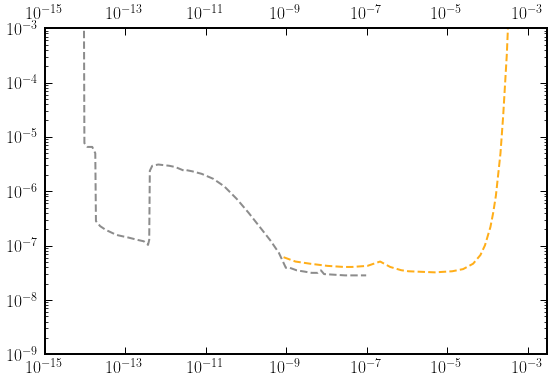

In [25]:

# ====================================================
# Plot Parameters
mAp_pltmin = 1e-15 # eV
mAp_pltmax = 3e-3  # eV

eps_pltmin = 1e-9
eps_pltmax = 1e-3

majortick_len = 7 # length of major tick
minortick_len = 4 # length of minor tick

twin_majortick_len = majortick_len  # length of twin major tick
twin_minortick_len = minortick_len  # length of twin minor tick
# ====================================================



# Boundary of mu-y transition era
z_trans_0   = 10**3
z_trans_1   = 10**4
z_trans_2   = 3 * 10**5
z_dcs       = 2 * 10**6  # Redshif of double Compton scattering
z_max       = 10**10   # We just choose some very large z_max value

mAp_trans_0 = np.sqrt( mAsq(z_trans_0, 0) ) # in eV
mAp_trans_1 = np.sqrt( mAsq(z_trans_1, 0) ) # in eV
mAp_trans_2 = np.sqrt( mAsq(z_trans_2, 0) ) # in eV
mAp_dcs     = np.sqrt( mAsq(z_dcs, 0) )     # in eV
mAp_max     = np.sqrt( mAsq(z_max, 0) )     # in eV


# Delta 95%CL, From PDG Statistics
TS_choose = 2.71

TS_Reg = 0.001


fig, ax = plt.subplots()

ax1 = ax.twiny()

fig.set_size_inches(9, 6)

ax.set_xscale('log')
ax.set_yscale('log')
ax1.set_xscale('log')    # twin_y axis
ax1.set_yscale('log')    # twin_y axis

ax.set_xlim(mAp_pltmin, mAp_pltmax)
ax.set_ylim(eps_pltmin, eps_pltmax)
ax1.set_xlim(mAp_pltmin, mAp_pltmax)    # twin_y axis
ax1.set_ylim(eps_pltmin, eps_pltmax)    # twin_y axis

ax.plot( Caputo_20_FIRAS_ho_2Dary[0] , Caputo_20_FIRAS_ho_2Dary[1], linewidth=2, label = r'Caputo et.al. 20: Homogeneous', color = 'gray', linestyle = 'dashed')
#ax.plot( Mirizzi_09_FIRAS_2Dary[0] , Mirizzi_09_FIRAS_2Dary[1], label = r'Mirizzi et.al. 2009', color = 'red')
ax.plot( McDermott_20_FIRAS_2Dary[0]     , McDermott_20_FIRAS_2Dary[1], linewidth=2, label = r'McDermott et.al. 20', color = 'orange', linestyle = 'dashed')

ax.plot( Greens_trans_5p8e4_1p88[0], Greens_trans_5p8e4_1p88[1], label = r' $z_\mathrm{trans} = 5.8 \times 10^4$, $\mathrm{Power}=1.88$', color='red',  linewidth=2.0)


ax.axvspan(mAp_trans_1, mAp_trans_2, alpha=0.1, facecolor='blue', edgecolor=None)
ax.text(1.3e-7, 1e-6, r'$\mu$-y era', fontsize=17, color='blue', rotation=-90)

ax.axvspan(mAp_trans_0, mAp_trans_1, alpha=0.1, facecolor='red', edgecolor=None)
ax.text(0.9e-9, 1.3e-6, r'y era', fontsize=17, color='red', rotation=-90)

ax.axvspan(mAp_trans_2, mAp_dcs, alpha=0.1, facecolor='green', edgecolor=None)
ax.text(7e-6, 1.3e-6, r'$\mu$ era', fontsize=17, color='green', rotation=-90)

ax.axvspan(mAp_dcs, mAp_max, alpha=0.1, facecolor='orange', edgecolor=None)
ax.text(3e-4, 1.3e-6, r'T era', fontsize=17, color='orange', rotation=-90)


ax.xaxis.set_major_locator( mticker.LogLocator(numticks=999, base=100) )
ax.xaxis.set_minor_locator( mticker.LogLocator(numticks=999, base=10,subs=(.1, .2, .3, .4, .5, .6, .7, .8, .9)))

ax.tick_params(which='major', length=majortick_len, labelbottom=True)
ax.tick_params(which='minor', length=minortick_len, labelbottom=False)

ax.tick_params(axis='both', left=True, top=True, right=True, bottom=True, labelleft=True, labeltop=False, labelright=False, labelbottom=True)


plt.setp(ax.xaxis.get_ticklabels(), rotation=0)

ax.set_xlabel(r'$m_{A^\prime}$[eV]',fontsize=19)
ax.set_ylabel(r'$\epsilon$',fontsize=19, rotation=0)

ax1.xaxis.set_major_locator( mticker.LogLocator(numticks=999, base=10) )
ax1.xaxis.set_minor_locator( mticker.LogLocator(numticks=999, base=10,subs=(.1, .2, .3, .4, .5, .6, .7, .8, .9)))

ax1.tick_params(which='major', length=twin_majortick_len)
ax1.tick_params(axis='both', left=False, top=True, right=False, bottom=True, labelleft=False, labeltop=False, labelright=False, labelbottom=False)


ax.legend(bbox_to_anchor=(0.29, 0.73), loc = 'center',fontsize=12.0)
fig.suptitle(r"\bf{COBE-FIRAS Constraints: $\mathrm{TS}=-2.71$}", y=0.94, fontsize=18)

plt.savefig('../plots/mAp_eps_plt_2.pdf',dpi=350)

In [26]:
# ====================================================
# Different eras: z and mAp ranges

# Boundary of mu-y transition era
z_trans_0   = 10**3
z_trans_1   = 10**4
z_trans_2   = 3 * 10**5
z_dcs       = 2 * 10**6  # Redshif of double Compton scattering
z_max   =   10**10   # We choose some very large z_max value

mAp_trans_0 = np.sqrt( mAsq(z_trans_0, 0) ) # in eV
mAp_trans_1 = np.sqrt( mAsq(z_trans_1, 0) ) # in eV
mAp_trans_2 = np.sqrt( mAsq(z_trans_2, 0) ) # in eV
mAp_dcs     = np.sqrt( mAsq(z_dcs, 0) )     # in eV
mAp_max     = np.sqrt( mAsq(z_max, 0) )     # in eV

# ====================================================



# COBE-FIRAS constraint (fiducial)
# run for many points and change this line with below line
mAp_eps_FIRAS_fidu_2Dary = np.array( pd.read_excel('../data/mAp_eps_FIRAS_fidu.xlsx') )
#mAp_eps_FIRAS_fidu_2Dary = Greens_trans_5p8e4_1p88

# Fiducial (mAp,eps) COBE-FIRAS constraint
mAp_trans_fidu = mAp_eps_FIRAS_fidu_2Dary[0]
eps_trans_fidu = mAp_eps_FIRAS_fidu_2Dary[1]




# Caputo et al from 2002.05165 COBE-FIRAS constraint
mAp_Caputo_20_FIRAS_inho   = Caputo_20_FIRAS_inho_2Dary[0]  # mAp list
eps_Caputo_20_FIRAS_inho   = Caputo_20_FIRAS_inho_2Dary[1]  # eps list

# Caputo et al from 2002.05165 PIXIE projection
mAp_Caputo_20_PIXIE_inho   = Caputo_20_PIXIE_inho_2Dary[0]  # mAp list
eps_Caputo_20_PIXIE_inho   = Caputo_20_PIXIE_inho_2Dary[1]  # eps list



# mAp_min/max of dashed region
mAp_min_dashed = 5*10**(-7)  # eV
mAp_max_dashed = mAp_trans_2 # eV

# Fiducial (mAp,eps) COBE-FIRAS constraint: Left(L)
mAp_trans_fidu_L = mAp_trans_fidu[mAp_trans_fidu<mAp_min_dashed]
eps_trans_fidu_L = eps_trans_fidu[mAp_trans_fidu<mAp_min_dashed]

# Fiducial (mAp,eps) COBE-FIRAS constraint: Right(R)
mAp_trans_fidu_R = mAp_trans_fidu[mAp_trans_fidu>mAp_max_dashed]
eps_trans_fidu_R = eps_trans_fidu[mAp_trans_fidu>mAp_max_dashed]

# Fiducial (mAp,eps) COBE-FIRAS constraint: Middle(M)
mAp_trans_fidu_M = mAp_trans_fidu[np.logical_and(mAp_trans_fidu>=mAp_min_dashed,mAp_trans_fidu<=mAp_max_dashed)]
eps_trans_fidu_M = eps_trans_fidu[np.logical_and(mAp_trans_fidu>=mAp_min_dashed,mAp_trans_fidu<=mAp_max_dashed)]

# Fiducial (mAp,eps) COBE-FIRAS constraint: inhomogenenous extension
mAp_trans_fidu_inho = mAp_Caputo_20_FIRAS_inho[ mAp_Caputo_20_FIRAS_inho < mAp_trans_fidu_L[0] ]
eps_trans_fidu_inho = eps_Caputo_20_FIRAS_inho[ mAp_Caputo_20_FIRAS_inho < mAp_trans_fidu_L[0] ]

# Fiducial (mAp,eps) COBE-FIRAS constraint: 
mAp_trans_fidu_ = np.append( mAp_trans_fidu_inho , mAp_trans_fidu_L )
eps_trans_fidu_ = np.append( eps_trans_fidu_inho , eps_trans_fidu_L )

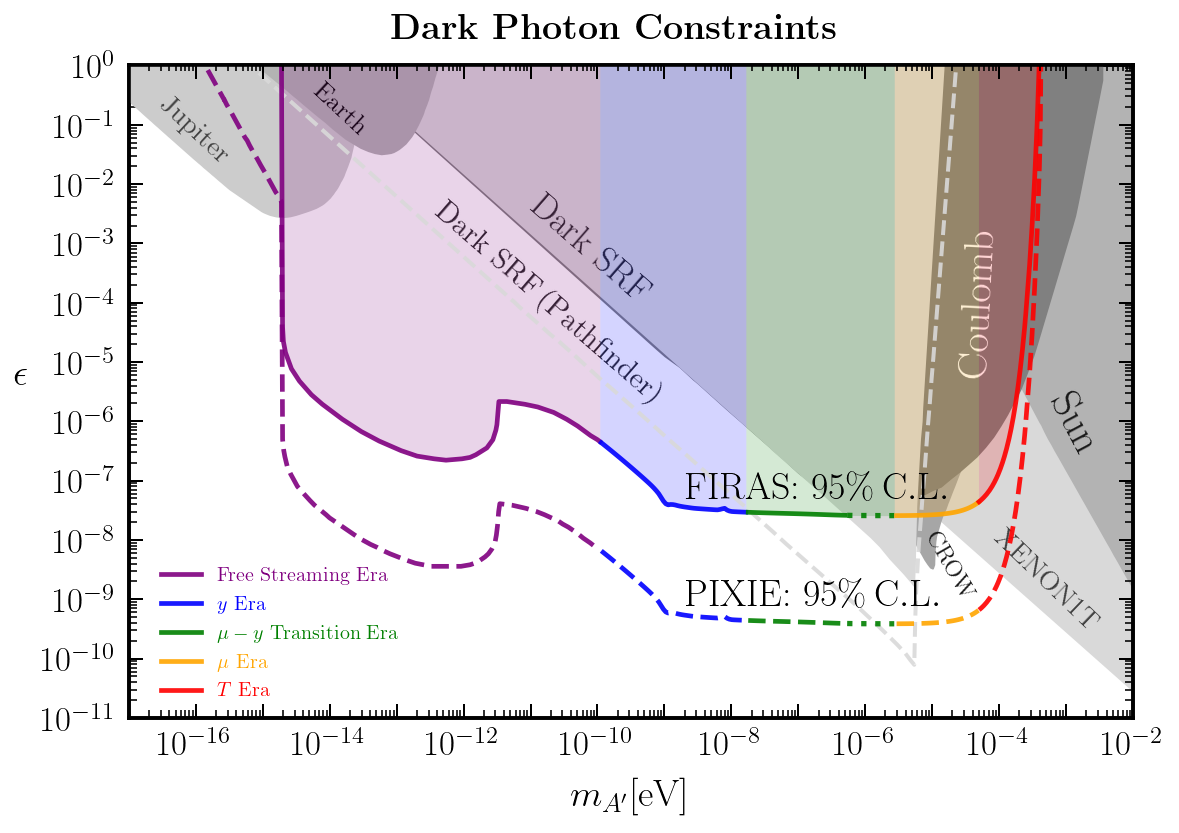

In [31]:

# ====================================================
# Plot Parameters
mAp_pltmin = 1e-17 # eV
mAp_pltmax = 1e-2  # eV

eps_pltmin = 1e-11
eps_pltmax = 1e0

majortick_len = 7 # length of major tick
minortick_len = 4 # length of minor tick

twin_majortick_len = majortick_len  # length of twin major tick
twin_minortick_len = minortick_len  # length of twin minor tick

# ====================================================
# color for different eras
color_free = 'purple'
color_y    = 'blue'
color_trans= 'green'
color_mu   = 'orange'
color_T    = 'red'
# ====================================================



fig, ax = plt.subplots()

ax1 = ax.twiny()

fig.set_size_inches(9, 6)

ax.set_xscale('log')
ax.set_yscale('log')
ax1.set_xscale('log')    # twin_y axis
ax1.set_yscale('log')    # twin_y axis


ax.set_xlim(mAp_pltmin, mAp_pltmax)
ax.set_ylim(eps_pltmin, eps_pltmax)
ax1.set_xlim(mAp_pltmin, mAp_pltmax)    # twin_y axis
ax1.set_ylim(eps_pltmin, eps_pltmax)    # twin_y axis


color_XenonSolar       = lighten_color('gray', 0.3)
color_SolarLuminosity  = lighten_color('gray', 0.6)
color_Cavendish        = lighten_color('gray', 1)
color_CROW             = lighten_color('gray', 0.7)
color_DarkSRF          = lighten_color('gray', 0.3)
color_Jupiter          = lighten_color('gray', 0.4)
color_Earth            = lighten_color('gray', 0.6)


color_XenonSolar_label       = lighten_color('gray', 1.5)
color_SolarLuminosity_label  = lighten_color('black', 0.9)
color_Cavendish_label        = lighten_color('white', 1)
color_CROW_label             = lighten_color('gray', 1.8)
color_DarkSRF_label          = lighten_color('gray', 1.7)
color_Jupiter_label          = lighten_color('gray', 1.5)
color_Earth_label            = lighten_color('gray', 2)

# Xenon-1T Solar (2112.12116 XENON1T Solar DP)
ax.fill_between(  XenonSolar_[0], XenonSolar_[1], max(XenonSolar_[1]), color=color_XenonSolar, alpha=1, zorder=0)

# Solar Luminosity (2304.12907 Li&Xu)
ax.fill_between(  SolarLuminosity_[0], SolarLuminosity_[1], max(SolarLuminosity_[1]), color=color_SolarLuminosity, alpha=1, zorder=1)

# Cavendish-Coulomb
ax.fill_between(  Cavendish_2Dary[0], Cavendish_2Dary[1], max(Cavendish_2Dary[1]), color=color_Cavendish, alpha=1, zorder=3)

# CROWS
ax.fill_between(  CROWS_[0], CROWS_[1], max(CROWS_[1]), color=color_CROW, alpha=1)

# Dark SRF Exclusion (2301.11512 Romanenko etc)
ax.fill_between(  DarkSRF_[0], DarkSRF_[1],max(DarkSRF_[1]),color=color_DarkSRF, alpha=1, zorder=5)

# Dark SRF Pathfinder Projection (2203.12714 Snowmass)
ax.plot(          DarkSRF23_Pathfinder_Proj_[0], DarkSRF23_Pathfinder_Proj_[1], color=color_DarkSRF, linestyle = 'dashed', linewidth=2.0, zorder=10)

# Jupiter
ax.fill_between(  Jupiter_2Dary[0], Jupiter_2Dary[1], max(Jupiter_2Dary[1]), color=color_Jupiter, alpha=1, zorder=5)

# Earth
ax.fill_between(  Earth_2Dary[0]  , Earth_2Dary[1]  , max(Earth_2Dary[1])  , color=color_Earth  , alpha=1, zorder=7)

# ======================================================================================
# COBE-FIRAS Plot Arrays: mAp and eps



# free streaming era
mAp_FIRAS_ary_free          = mAp_trans_fidu_[mAp_trans_fidu_<=mAp_trans_0]
eps_FIRAS_ary_free          = eps_trans_fidu_[mAp_trans_fidu_<=mAp_trans_0]

# y era
mAp_FIRAS_ary_y             = mAp_trans_fidu_[np.logical_and(mAp_trans_fidu_>mAp_trans_0,mAp_trans_fidu_<=mAp_trans_1)]
eps_FIRAS_ary_y             = eps_trans_fidu_[np.logical_and(mAp_trans_fidu_>mAp_trans_0,mAp_trans_fidu_<mAp_trans_1)]

# transition era (solid)
mAp_FIRAS_ary_trans_solid   = mAp_trans_fidu_[np.logical_and(mAp_trans_fidu_>mAp_trans_1,mAp_trans_fidu_<=mAp_trans_2)]
eps_FIRAS_ary_trans_solid   = eps_trans_fidu_[np.logical_and(mAp_trans_fidu_>mAp_trans_1,mAp_trans_fidu_<mAp_trans_2)]

# transition era (dotted)
mAp_FIRAS_ary_trans_dotted  = mAp_trans_fidu_M
eps_FIRAS_ary_trans_dotted  = eps_trans_fidu_M

# transition era (total)
mAp_FIRAS_ary_trans         = np.append(mAp_FIRAS_ary_trans_solid,mAp_FIRAS_ary_trans_dotted)
eps_FIRAS_ary_trans         = np.append(eps_FIRAS_ary_trans_solid,eps_FIRAS_ary_trans_dotted)

# mu era
mAp_FIRAS_ary_mu            = mAp_trans_fidu_R[np.logical_and(mAp_trans_fidu_R>=mAp_max_dashed,mAp_trans_fidu_R<mAp_dcs)]
eps_FIRAS_ary_mu            = eps_trans_fidu_R[np.logical_and(mAp_trans_fidu_R>=mAp_max_dashed,mAp_trans_fidu_R<mAp_dcs)]

# T era
mAp_FIRAS_ary_T             = mAp_trans_fidu_R[mAp_trans_fidu_R>=mAp_dcs]
eps_FIRAS_ary_T             = eps_trans_fidu_R[mAp_trans_fidu_R>=mAp_dcs]
# ======================================================================================
# PIXIE Plot Arrays: mAp and eps

PIXIE_rescale = 1.5e-2

# Caputo et al (2002.05165 PIXIE) projection inhomogeneous  

mAp_20_PIXIE_inho_ = Caputo_20_PIXIE_inho_[0]
eps_20_PIXIE_inho_ = Caputo_20_PIXIE_inho_[1]

# free streaming era
mAp_PIXIE_ary_free          = mAp_20_PIXIE_inho_[mAp_20_PIXIE_inho_<=mAp_trans_0]
eps_PIXIE_ary_free          = eps_20_PIXIE_inho_[mAp_20_PIXIE_inho_<=mAp_trans_0]

# y era
mAp_PIXIE_ary_y             = mAp_trans_fidu_[np.logical_and(mAp_trans_fidu_>mAp_trans_0,mAp_trans_fidu_<=mAp_trans_1)]
eps_PIXIE_ary_y             = PIXIE_rescale * eps_trans_fidu_[np.logical_and(mAp_trans_fidu_>mAp_trans_0,mAp_trans_fidu_<mAp_trans_1)]

# transition era (solid)
mAp_PIXIE_ary_tran_solid    = mAp_trans_fidu_[np.logical_and(mAp_trans_fidu_>mAp_trans_1,mAp_trans_fidu_<=mAp_trans_2)]
eps_PIXIE_ary_tran_solid    = PIXIE_rescale * eps_trans_fidu_[np.logical_and(mAp_trans_fidu_>mAp_trans_1,mAp_trans_fidu_<mAp_trans_2)]

# transition era (dotted)
mAp_PIXIE_ary_tran_dotted   = mAp_trans_fidu_M
eps_PIXIE_ary_tran_dotted   = PIXIE_rescale * eps_trans_fidu_M

# transition era (total)
mAp_PIXIE_ary_tran          = np.append(mAp_PIXIE_ary_tran_solid,mAp_PIXIE_ary_tran_dotted)
eps_PIXIE_ary_tran          = np.append(eps_PIXIE_ary_tran_solid,eps_PIXIE_ary_tran_dotted)

# mu era
mAp_PIXIE_ary_mu            = mAp_trans_fidu_R[np.logical_and(mAp_trans_fidu_R>=mAp_max_dashed,mAp_trans_fidu_R<mAp_dcs)]
eps_PIXIE_ary_mu            = PIXIE_rescale * eps_trans_fidu_R[np.logical_and(mAp_trans_fidu_R>=mAp_max_dashed,mAp_trans_fidu_R<mAp_dcs)]

# T era
mAp_PIXIE_ary_T             = mAp_trans_fidu_R[mAp_trans_fidu_R>=mAp_dcs]
eps_PIXIE_ary_T             = PIXIE_rescale * eps_trans_fidu_R[mAp_trans_fidu_R>=mAp_dcs]
# ======================================================================================

# COBE-FIRAS constraint: Line
linewidth_FIRAS_solid  = 2.35
linewidth_FIRAS_dotted = 2.65

ax.plot( mAp_FIRAS_ary_free        , eps_FIRAS_ary_free         , color=color_free ,  linewidth=linewidth_FIRAS_solid    , zorder=10, label = r'Free Streaming Era' )
ax.plot( mAp_FIRAS_ary_y           , eps_FIRAS_ary_y            , color=color_y    ,  linewidth=linewidth_FIRAS_solid    , zorder=10, label = r'$y$ Era'            )
ax.plot( mAp_FIRAS_ary_trans_solid , eps_FIRAS_ary_trans_solid  , color=color_trans,  linewidth=linewidth_FIRAS_solid    , zorder=10, label = r'$\mu-y$ Transition Era'     )
ax.plot( mAp_FIRAS_ary_trans_dotted, eps_FIRAS_ary_trans_dotted , color=color_trans,  linewidth=linewidth_FIRAS_dotted   , zorder=10,       linestyle = 'dotted')
ax.plot( mAp_FIRAS_ary_mu          , eps_FIRAS_ary_mu           , color=color_mu   ,  linewidth=linewidth_FIRAS_solid    , zorder=10, label = r'$\mu$ Era'          )
ax.plot( mAp_FIRAS_ary_T           , eps_FIRAS_ary_T            , color=color_T    ,  linewidth=linewidth_FIRAS_solid    , zorder=10, label = r'$T$ Era'            )

# COBE-FIRAS constraint: Shade
alpha_FIRAS = 0.17

ax.fill_between(  mAp_FIRAS_ary_free                                      , eps_FIRAS_ary_free                                      , max(np.ones(len(mAp_FIRAS_ary_free)))         ,linewidth=0.0 , color=color_free  , alpha=alpha_FIRAS, zorder=10)
ax.fill_between(  np.append(mAp_FIRAS_ary_free[-1], mAp_FIRAS_ary_y    )  , np.append(eps_FIRAS_ary_free[-1], eps_FIRAS_ary_y    )  , max(np.ones(len(mAp_FIRAS_ary_y)+1))          ,linewidth=0.0 , color=color_y     , alpha=alpha_FIRAS, zorder=10)
ax.fill_between(  np.append(mAp_FIRAS_ary_y[-1] , mAp_FIRAS_ary_trans)    , np.append(eps_FIRAS_ary_y[-1]   , eps_FIRAS_ary_trans)  , max(np.ones(len(mAp_FIRAS_ary_trans)+1))      ,linewidth=0.0 , color=color_trans , alpha=alpha_FIRAS, zorder=10)
ax.fill_between(  np.append(mAp_FIRAS_ary_trans[-1], mAp_FIRAS_ary_mu)    , np.append(eps_FIRAS_ary_trans[-1], eps_FIRAS_ary_mu)    , max(np.ones(len(mAp_FIRAS_ary_mu)+1))         ,linewidth=0.0 , color=color_mu    , alpha=alpha_FIRAS, zorder=10)
ax.fill_between(  np.append(mAp_FIRAS_ary_mu[-1], mAp_FIRAS_ary_T)        , np.append(eps_FIRAS_ary_mu[-1], eps_FIRAS_ary_T)        , max(np.ones(len(mAp_FIRAS_ary_T)+1))          ,linewidth=0.0 , color=color_T     , alpha=alpha_FIRAS, zorder=10)


# PIXIE projection: Line
# linewidth_PIXIE = 2.3
linewidth_PIXIE_dashed = 2.35
linewidth_PIXIE_dotted = 2.65

ax.plot( mAp_PIXIE_ary_free        , eps_PIXIE_ary_free        , color=color_free  , linestyle='dashed' , linewidth=linewidth_PIXIE_dashed , zorder=10)
ax.plot( mAp_PIXIE_ary_y           , eps_PIXIE_ary_y           , color=color_y     , linestyle='dashed' , linewidth=linewidth_PIXIE_dashed , zorder=10)
ax.plot( mAp_PIXIE_ary_tran_solid  , eps_PIXIE_ary_tran_solid  , color=color_trans , linestyle='dashed' , linewidth=linewidth_PIXIE_dashed , zorder=10)
ax.plot( mAp_PIXIE_ary_tran_dotted , eps_PIXIE_ary_tran_dotted , color=color_trans , linestyle='dotted' , linewidth=linewidth_PIXIE_dotted , zorder=10)
ax.plot( mAp_PIXIE_ary_mu          , eps_PIXIE_ary_mu          , color=color_mu    , linestyle='dashed' , linewidth=linewidth_PIXIE_dashed , zorder=10)
ax.plot( mAp_PIXIE_ary_T           , eps_PIXIE_ary_T           , color=color_T     , linestyle='dashed' , linewidth=linewidth_PIXIE_dashed , zorder=10)


ax.text(7e-5    , 3e-10  , r'XENON1T'                , fontsize=14 , color=color_XenonSolar_label      , rotation=-44 , zorder=9)
ax.text(4.5e-4  , 3e-7   , r'Sun'                    , fontsize=21 , color=color_SolarLuminosity_label , rotation=-62 , zorder=9)
ax.text(2.3e-5  , 7e-6   , r'Coulomb'                , fontsize=21 , color=color_Cavendish_label       , rotation=87  , zorder=9)
ax.text(7e-6    , 1e-9   , r'CROW'                   , fontsize=12 , color=color_CROW_label            , rotation=-60 , zorder=9)
ax.text(8e-12   , 1e-4   , r'Dark SRF'               , fontsize=18 , color=color_DarkSRF_label         , rotation=-41 , zorder=9)
ax.text(3e-13   , 2e-6   , r'Dark SRF\,(Pathfinder)' , fontsize=15 , color=color_DarkSRF_label         , rotation=-41 , zorder=9)
ax.text(2.5e-17 , 2.3e-2 , r'Jupiter'                , fontsize=14 , color=color_Jupiter_label         , rotation=-43 , zorder=9)
ax.text(5e-15   , 7e-2   , r'Earth'                  , fontsize=13 , color=color_Earth_label           , rotation=-43 , zorder=9)

# ======================================================================================
# Label of 'FIRAS'
fontsize_FIRAS = 19

ax.text(2e-9, 5e-8, "FIRAS: $95\%\,\mathrm{C.L.}$", color='black', zorder=10, fontsize=fontsize_FIRAS, fontweight='bold')
# ======================================================================================
# Label of 'PIXIE'
fontsize_PIXIE = fontsize_FIRAS

ax.text(2e-9, 8e-10, "PIXIE: $95\%\,\mathrm{C.L.}$", color='black', zorder=10, fontsize=fontsize_PIXIE, fontweight='bold')
# ======================================================================================


ax.xaxis.set_major_locator( mticker.LogLocator(numticks=999, base=100) )
ax.xaxis.set_minor_locator( mticker.LogLocator(numticks=999, base=10,subs=(.1, .2, .3, .4, .5, .6, .7, .8, .9)))
ax.yaxis.set_major_locator( mticker.LogLocator(numticks=999, base=10) )
ax.yaxis.set_minor_locator( mticker.LogLocator(numticks=999, base=10,subs=(.1, .2, .3, .4, .5, .6, .7, .8, .9)))


ax.tick_params(which='major', length=majortick_len, labelbottom=True)
ax.tick_params(which='minor', length=minortick_len, labelbottom=False)

ax.tick_params(axis='both', left=True, top=True, right=True, bottom=True, labelleft=True, labeltop=False, labelright=False, labelbottom=True)

plt.setp(ax.xaxis.get_ticklabels(), rotation=0)

ax.set_xlabel(r'$m_{A^\prime}$[eV]',fontsize=19)
ax.set_ylabel(r'$\epsilon$',fontsize=19, rotation=0)

ax1.xaxis.set_major_locator( mticker.LogLocator(numticks=999, base=10) )
ax1.xaxis.set_minor_locator( mticker.LogLocator(numticks=999, base=10,subs=(.1, .2, .3, .4, .5, .6, .7, .8, .9)) )

ax1.tick_params(which='major', length=twin_majortick_len)
ax1.tick_params(axis='both'  , left=False, top=True, right=False, bottom=True, labelleft=False, labeltop=False, labelright=False, labelbottom=False)


color_Era_ary = [color_free, color_y, color_trans, color_mu, color_T]

leg = ax.legend(ncol=1, loc='center', bbox_to_anchor=(0.15, 0.13), fontsize=10)

for color,text in zip(color_Era_ary,leg.get_texts()):
    text.set_color(color)

fig.suptitle(r"\bf{Dark Photon Constraints}", y=0.94, fontsize=18)

plt.savefig('../plots/mAp_eps_plt_allbounds.png', dpi=350)

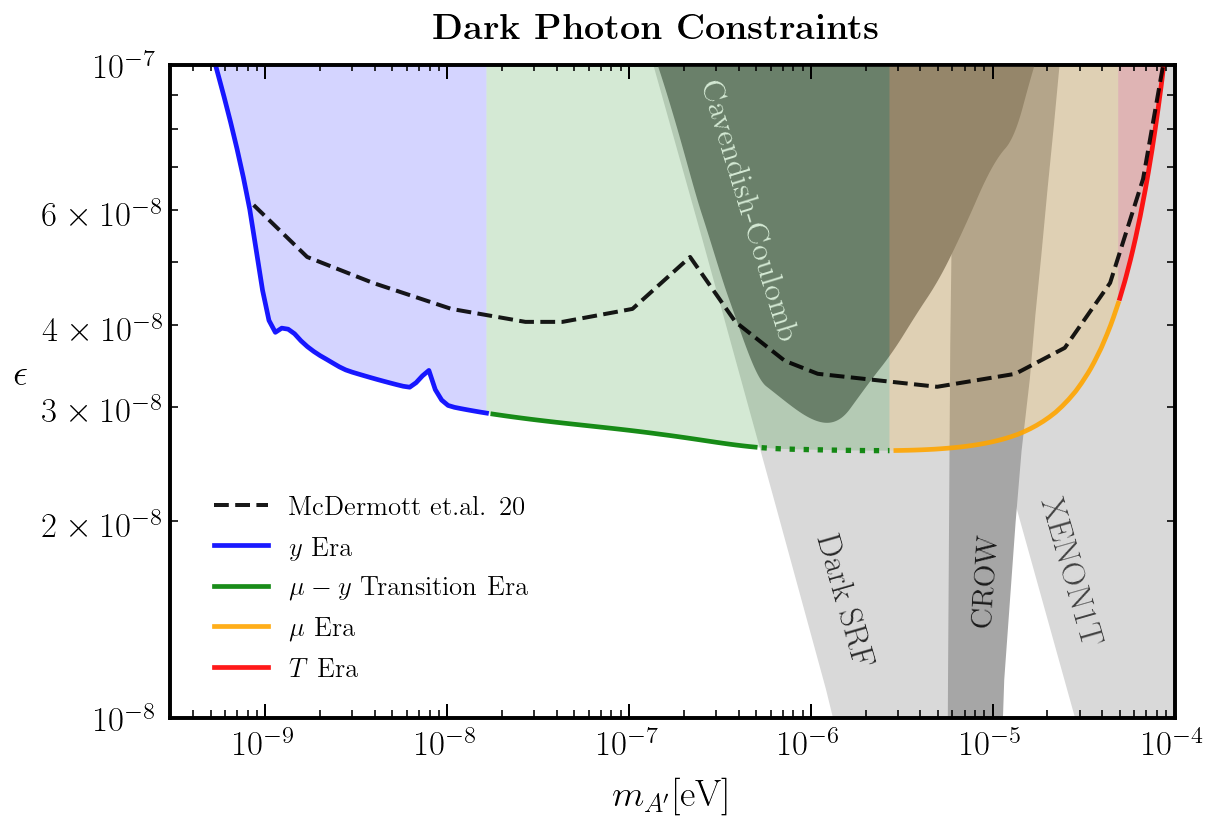

In [86]:
# ====================================================
# Plot Parameters
mAp_pltmin = 3e-10 # eV
mAp_pltmax = 1e-4  # eV

eps_pltmin = 1e-8
eps_pltmax = 1e-7

majortick_len = 7 # length of major tick
minortick_len = 4 # length of minor tick

twin_majortick_len = majortick_len  # length of twin major tick
twin_minortick_len = minortick_len  # length of twin minor tick
# ====================================================
set_matplotlib_formats('retina')

fig, ax = plt.subplots()

ax1 = ax.twiny()

fig.set_size_inches(9, 6)

ax.set_xscale('log')
ax.set_yscale('log')
ax1.set_xscale('log')    # twin_y axis
ax1.set_yscale('log')    # twin_y axis


ax.set_xlim(mAp_pltmin, mAp_pltmax)
ax.set_ylim(eps_pltmin, eps_pltmax)
ax1.set_xlim(mAp_pltmin, mAp_pltmax)    # twin_y axis
ax1.set_ylim(eps_pltmin, eps_pltmax)    # twin_y axis



# color_XenonSolar       = lighten_color('gold', 0.6)
# color_SolarLuminosity  = lighten_color('gray', 0.6)
# color_Cavendish        = lighten_color('red', 0.4)
# color_CROW             = lighten_color('cyan', 1.2)
# color_DarkSRF          = lighten_color('magenta', 0.3)
# color_Jupyter          = lighten_color('limegreen', 0.4)
# color_Earth            = lighten_color('blueviolet' , 0.5)


# color_XenonSolar_label       = lighten_color('gold', 1.7)
# color_SolarLuminosity_label  = lighten_color('black', 0.9)
# color_Cavendish_label        = lighten_color('red', 1.6)
# color_CROW_label             = lighten_color('cyan', 1.8)
# color_DarkSRF_label          = lighten_color('magenta', 1.2)
# color_Jupyter_label          = lighten_color('limegreen', 1.7)
# color_Earth_label            = lighten_color('blueviolet' , 1.8)


color_XenonSolar       = lighten_color('gray', 0.3)
color_SolarLuminosity  = lighten_color('gray', 0.6)
color_Cavendish        = lighten_color('gray', 1)
color_CROW             = lighten_color('gray', 0.7)
color_DarkSRF          = lighten_color('gray', 0.3)
color_Jupiter          = lighten_color('gray', 0.4)
color_Earth            = lighten_color('gray', 0.6)


color_XenonSolar_label       = lighten_color('gray', 1.5)
color_SolarLuminosity_label  = lighten_color('black', 0.9)
color_Cavendish_label        = lighten_color('white', 1)
color_CROW_label             = lighten_color('gray', 1.8)
color_DarkSRF_label          = lighten_color('gray', 1.7)
color_Jupiter_label          = lighten_color('gray', 1.5)
color_Earth_label            = lighten_color('gray', 2)




#Xenon-1T Solar (2112.12116 XENON1T Solar DP)
ax.fill_between(  XenonSolar_[0], XenonSolar_[1], max(XenonSolar_[1]), color=color_XenonSolar, alpha=1, zorder=0)


# Solar Luminosity (2304.12907 Li&Xu)
# ax.fill_between(  SolarLuminosity_2Dary_with_Lext[0], SolarLuminosity_2Dary_with_Lext[1], max(SolarLuminosity_2Dary_with_Lext[1]), color=color_SolarLuminosity, alpha=1, zorder=1)
# ax.plot(          SolarLuminosity_2Dary_with_Lext[0], SolarLuminosity_2Dary_with_Lext[1], label = r'Solar Luminosity', color=cols_default[5],linewidth=2.0)


# Cavendish-Coulomb
# with interpolation
mAp_Cavendish = 10**(np.linspace(np.log10(Cavendish_2Dary[0]).min(), np.log10(Cavendish_2Dary[0]).max(), 10000))

eps_Cavendish=interp1d(Cavendish_2Dary[0], Cavendish_2Dary[1], kind='quadratic')(mAp_Cavendish)
ax.fill_between(  mAp_Cavendish, eps_Cavendish, max(Cavendish_2Dary[1]), color=color_Cavendish, alpha=1, zorder=3)
#without interpolation, raw data
#ax.fill_between(  Cavendish_2Dary[0], Cavendish_2Dary[1], max(Cavendish_2Dary[1]), color=color_Cavendish, alpha=1, zorder=3)


#CROWS
ax.fill_between(  CROWS_[0], CROWS_[1], max(CROWS_[1]), color=color_CROW, alpha=1)


#Dark SRF PathFinder (2301.11512 Romanenko etc)
ax.fill_between(  DarkSRF_[0], DarkSRF_[1], max(DarkSRF_[1]), color=color_DarkSRF, alpha=1, zorder=1)


#ax.plot( mAp_FIRAS_ho , eps_FIRAS_ho, label = r'Homogeneous', color = 'blue', linestyle = 'dashed', linewidth=2.0, zorder=11)

ax.plot( McDermott_20_FIRAS_2Dary[0]     , McDermott_20_FIRAS_2Dary[1], linewidth=2, label = r'McDermott et.al. 20', color = 'black', linestyle = 'dashed', zorder=12)




# COBE-FIRAS constraint: Line
linewidth_FIRAS_solid  = 2.35
linewidth_FIRAS_dotted = 2.65

#ax.plot( mAp_FIRAS_ary_free        , eps_FIRAS_ary_free         , color=color_free ,  linewidth=linewidth_FIRAS_solid    , zorder=10, label = r'Free Streaming Era' )
ax.plot( mAp_FIRAS_ary_y           , eps_FIRAS_ary_y            , color=color_y    ,  linewidth=linewidth_FIRAS_solid    , zorder=10, label = r'$y$ Era'            )
ax.plot( mAp_FIRAS_ary_trans_solid , eps_FIRAS_ary_trans_solid  , color=color_trans,  linewidth=linewidth_FIRAS_solid    , zorder=10, label = r'$\mu-y$ Transition Era'     )
ax.plot( mAp_FIRAS_ary_trans_dotted, eps_FIRAS_ary_trans_dotted , color=color_trans,  linewidth=linewidth_FIRAS_dotted   , zorder=10,       linestyle = 'dotted')
ax.plot( mAp_FIRAS_ary_mu          , eps_FIRAS_ary_mu           , color=color_mu   ,  linewidth=linewidth_FIRAS_solid    , zorder=10, label = r'$\mu$ Era'          )
ax.plot( mAp_FIRAS_ary_T           , eps_FIRAS_ary_T            , color=color_T    ,  linewidth=linewidth_FIRAS_solid    , zorder=10, label = r'$T$ Era'            )

# COBE-FIRAS constraint: Shade
alpha_FIRAS = 0.17

#ax.fill_between(  mAp_FIRAS_ary_free                                      , eps_FIRAS_ary_free                                      , max(np.ones(len(mAp_FIRAS_ary_free)))         ,linewidth=0.0 , color=color_free  , alpha=alpha_FIRAS, zorder=10)
ax.fill_between(  np.append(mAp_FIRAS_ary_free[-1], mAp_FIRAS_ary_y    )  , np.append(eps_FIRAS_ary_free[-1], eps_FIRAS_ary_y    )  , max(np.ones(len(mAp_FIRAS_ary_y)+1))          ,linewidth=0.0 , color=color_y     , alpha=alpha_FIRAS, zorder=10)
ax.fill_between(  np.append(mAp_FIRAS_ary_y[-1] , mAp_FIRAS_ary_trans)    , np.append(eps_FIRAS_ary_y[-1]   , eps_FIRAS_ary_trans)  , max(np.ones(len(mAp_FIRAS_ary_trans)+1))      ,linewidth=0.0 , color=color_trans , alpha=alpha_FIRAS, zorder=10)
ax.fill_between(  np.append(mAp_FIRAS_ary_trans[-1], mAp_FIRAS_ary_mu)    , np.append(eps_FIRAS_ary_trans[-1], eps_FIRAS_ary_mu)    , max(np.ones(len(mAp_FIRAS_ary_mu)+1))         ,linewidth=0.0 , color=color_mu    , alpha=alpha_FIRAS, zorder=10)
ax.fill_between(  np.append(mAp_FIRAS_ary_mu[-1], mAp_FIRAS_ary_T)        , np.append(eps_FIRAS_ary_mu[-1], eps_FIRAS_ary_T)        , max(np.ones(len(mAp_FIRAS_ary_T)+1))          ,linewidth=0.0 , color=color_T     , alpha=alpha_FIRAS, zorder=10)





ax.text(1.7e-5 , 1.3e-8, r'XENON1T'          ,  fontweight='bold', fontsize=17, color=color_XenonSolar_label      , rotation=-74, zorder=9)
# ax.text(4.5e-4 , 3e-7 , r'Sun'              ,  fontweight='bold', fontsize=21, color=color_SolarLuminosity_label , rotation=-63, zorder=9)
ax.text(2.3e-7 , 3.8e-8 , r'Cavendish-Coulomb',  fontweight='bold', fontsize=16, color=color_Cavendish_label       , rotation=-73, zorder=9)
ax.text(7.5e-6 , 1.4e-8 , r'CROW'             ,  fontweight='bold', fontsize=15, color=color_CROW_label            , rotation=86, zorder=9)
ax.text(1e-6 , 1.2e-8, r'Dark SRF'          ,  fontweight='bold', fontsize=17, color=color_DarkSRF_label         , rotation=-74, zorder=9)



ax.xaxis.set_major_locator( mticker.LogLocator(numticks=999, base=10) )
ax.xaxis.set_minor_locator( mticker.LogLocator(numticks=999, base=10,subs=(.1, .2, .3, .4, .5, .6, .7, .8, .9)))
ax.yaxis.set_major_locator( mticker.LogLocator(numticks=999, base=10) )
ax.yaxis.set_minor_locator( mticker.LogLocator(numticks=999, base=10,subs=(.1, .2, .3, .4, .5, .6, .7, .8, .9)))


ax.tick_params(which='major', length=majortick_len, labelbottom=True)
ax.tick_params(which='minor', length=minortick_len, labelbottom=False)

ax.tick_params(axis='both', left=True, top=True, right=True, bottom=True, labelleft=True, labeltop=False, labelright=False, labelbottom=True)

plt.setp(ax.xaxis.get_ticklabels(), rotation=0)

ax.set_xlabel(r'$m_{A^\prime}$[eV]',fontsize=19)
ax.set_ylabel(r'$\epsilon$',fontsize=19, rotation=0)

ax1.xaxis.set_major_locator( mticker.LogLocator(numticks=999, base=10) )
ax1.xaxis.set_minor_locator( mticker.LogLocator(numticks=999, base=10,subs=(.1, .2, .3, .4, .5, .6, .7, .8, .9)))

ax1.tick_params(which='major', length=twin_majortick_len)
ax1.tick_params(axis='both', left=False, top=True, right=False, bottom=True, labelleft=False, labeltop=False, labelright=False, labelbottom=False)

ax.legend(bbox_to_anchor=(0.2, 0.2), loc = 'center',fontsize=13.5)

fig.suptitle(r"\bf{Dark Photon Constraints}", y=0.94, fontsize=18)

# plt.savefig('mAp_eps_plt_allbounds.pdf')
plt.savefig('../plots/mAp_eps_plt_zoomin2.png', dpi=350)